In [1]:
import lmfit
import numpy as np
import matplotlib.pyplot as plt
import os
from mpdaf.obj import Cube
from mpdaf.drs import PixTable
from matplotlib import rc
from PyAstronomy import pyasl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})
rc('text', usetex=True)

path = os.path.join(os.sep, 'Users', 'lzq', 'Dropbox', 'Data', 'CGM', 'ESO_DEEP_offset.fits')
cube = Cube(path)

# Calculate the white image
image_white = cube.sum(axis=0)
p, q = image_white.peak()['p'], image_white.peak()['q']

[[0.03137255 0.18823529 0.41960784 1.        ]]


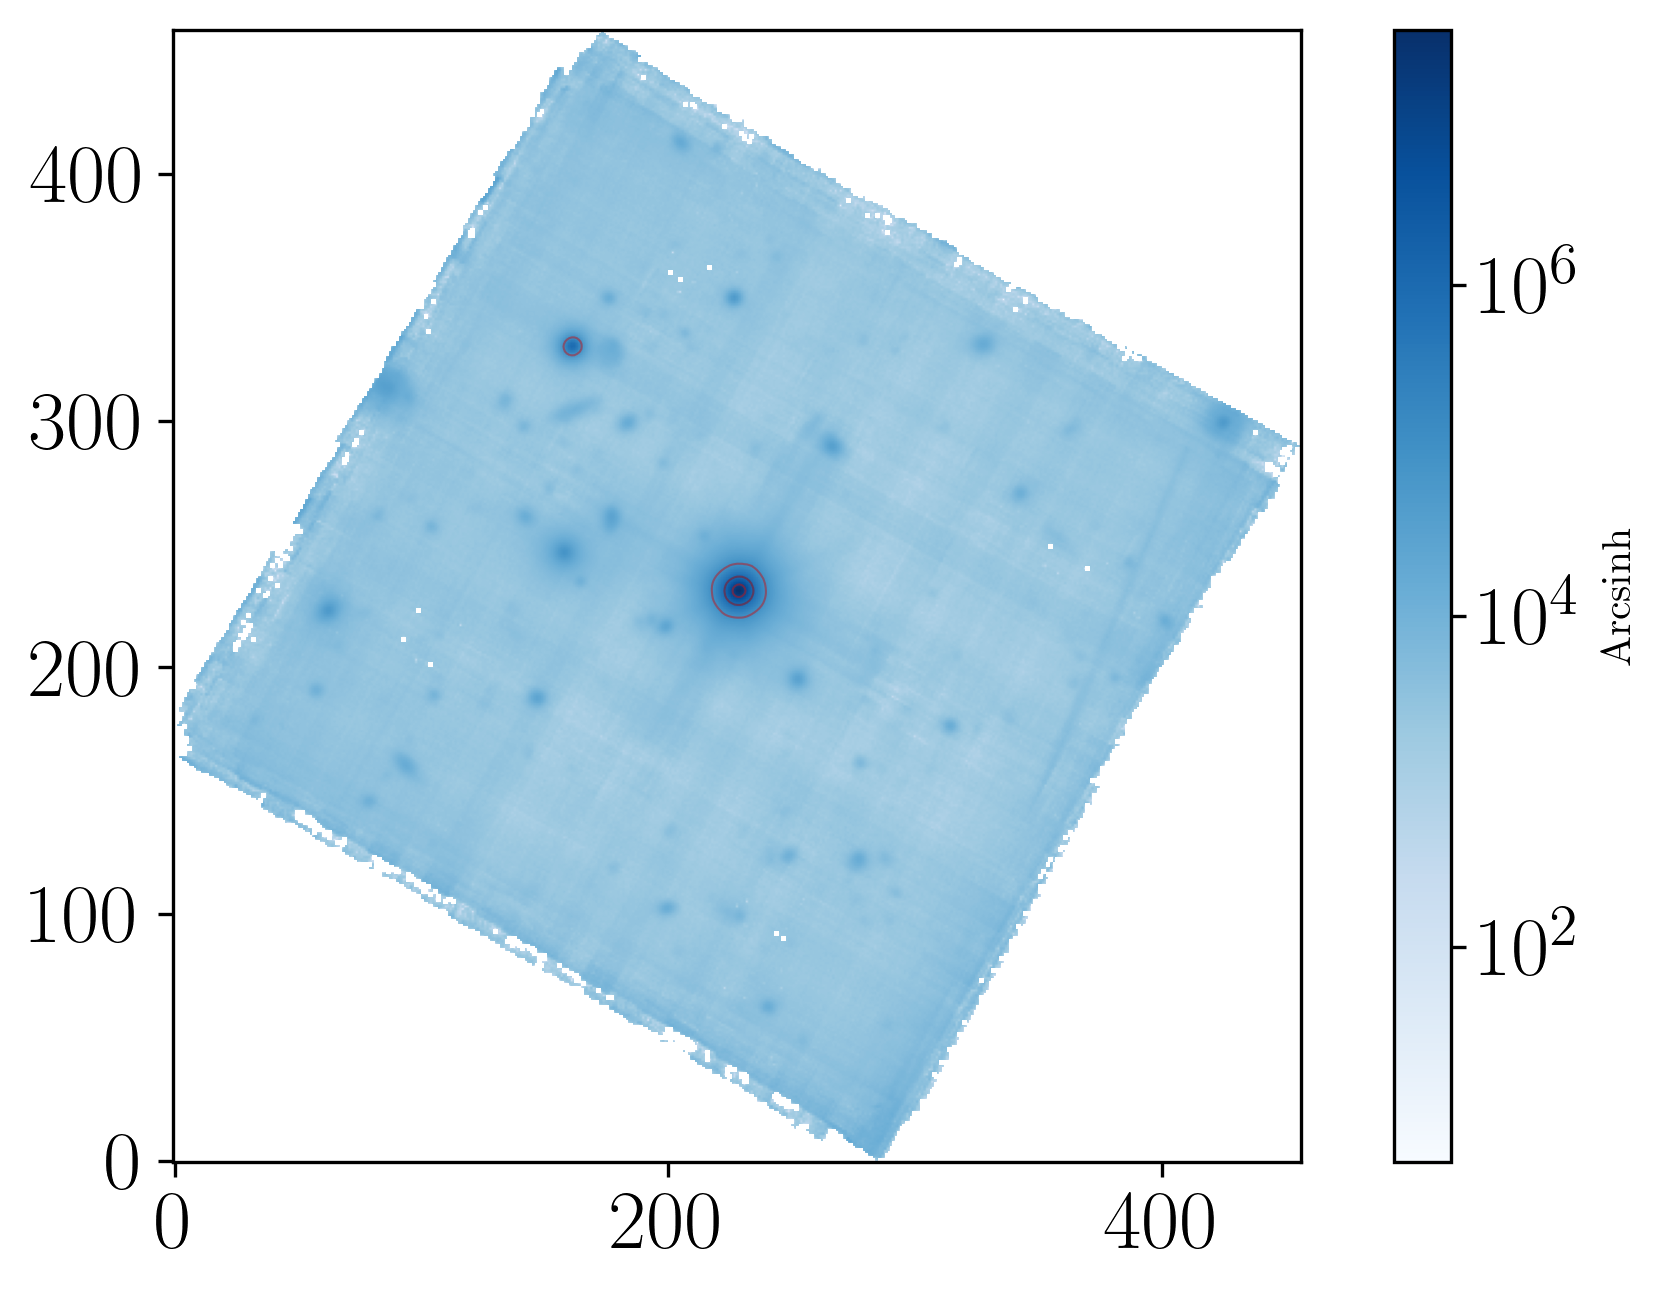

In [94]:
Blues = cm.get_cmap('Blues', 256)
Reds = cm.get_cmap('Reds', 256)
newcolors = Blues(np.linspace(0, 1, 256))
newcolors_red = Reds(np.linspace(0, 1, 256))
newcmp = ListedColormap(newcolors)


print(newcolors[255:, :])
plt.figure(figsize=(8, 5), dpi=300)
plt.imshow(image_white.data, origin='lower', vmin=5, cmap=newcmp, norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar()
cbar.set_label(r'$\mathrm{Arcsinh}$')
plt.contour(image_white.data, levels=[1e5, 1e6, 1e7, 1e8], colors=newcolors_red[200::30, :], linewidths=0.5, alpha=0.5, norm=matplotlib.colors.LogNorm())
# plt.axis('off')
#plt.xlim(200, 250)
#plt.ylim(200, 250)

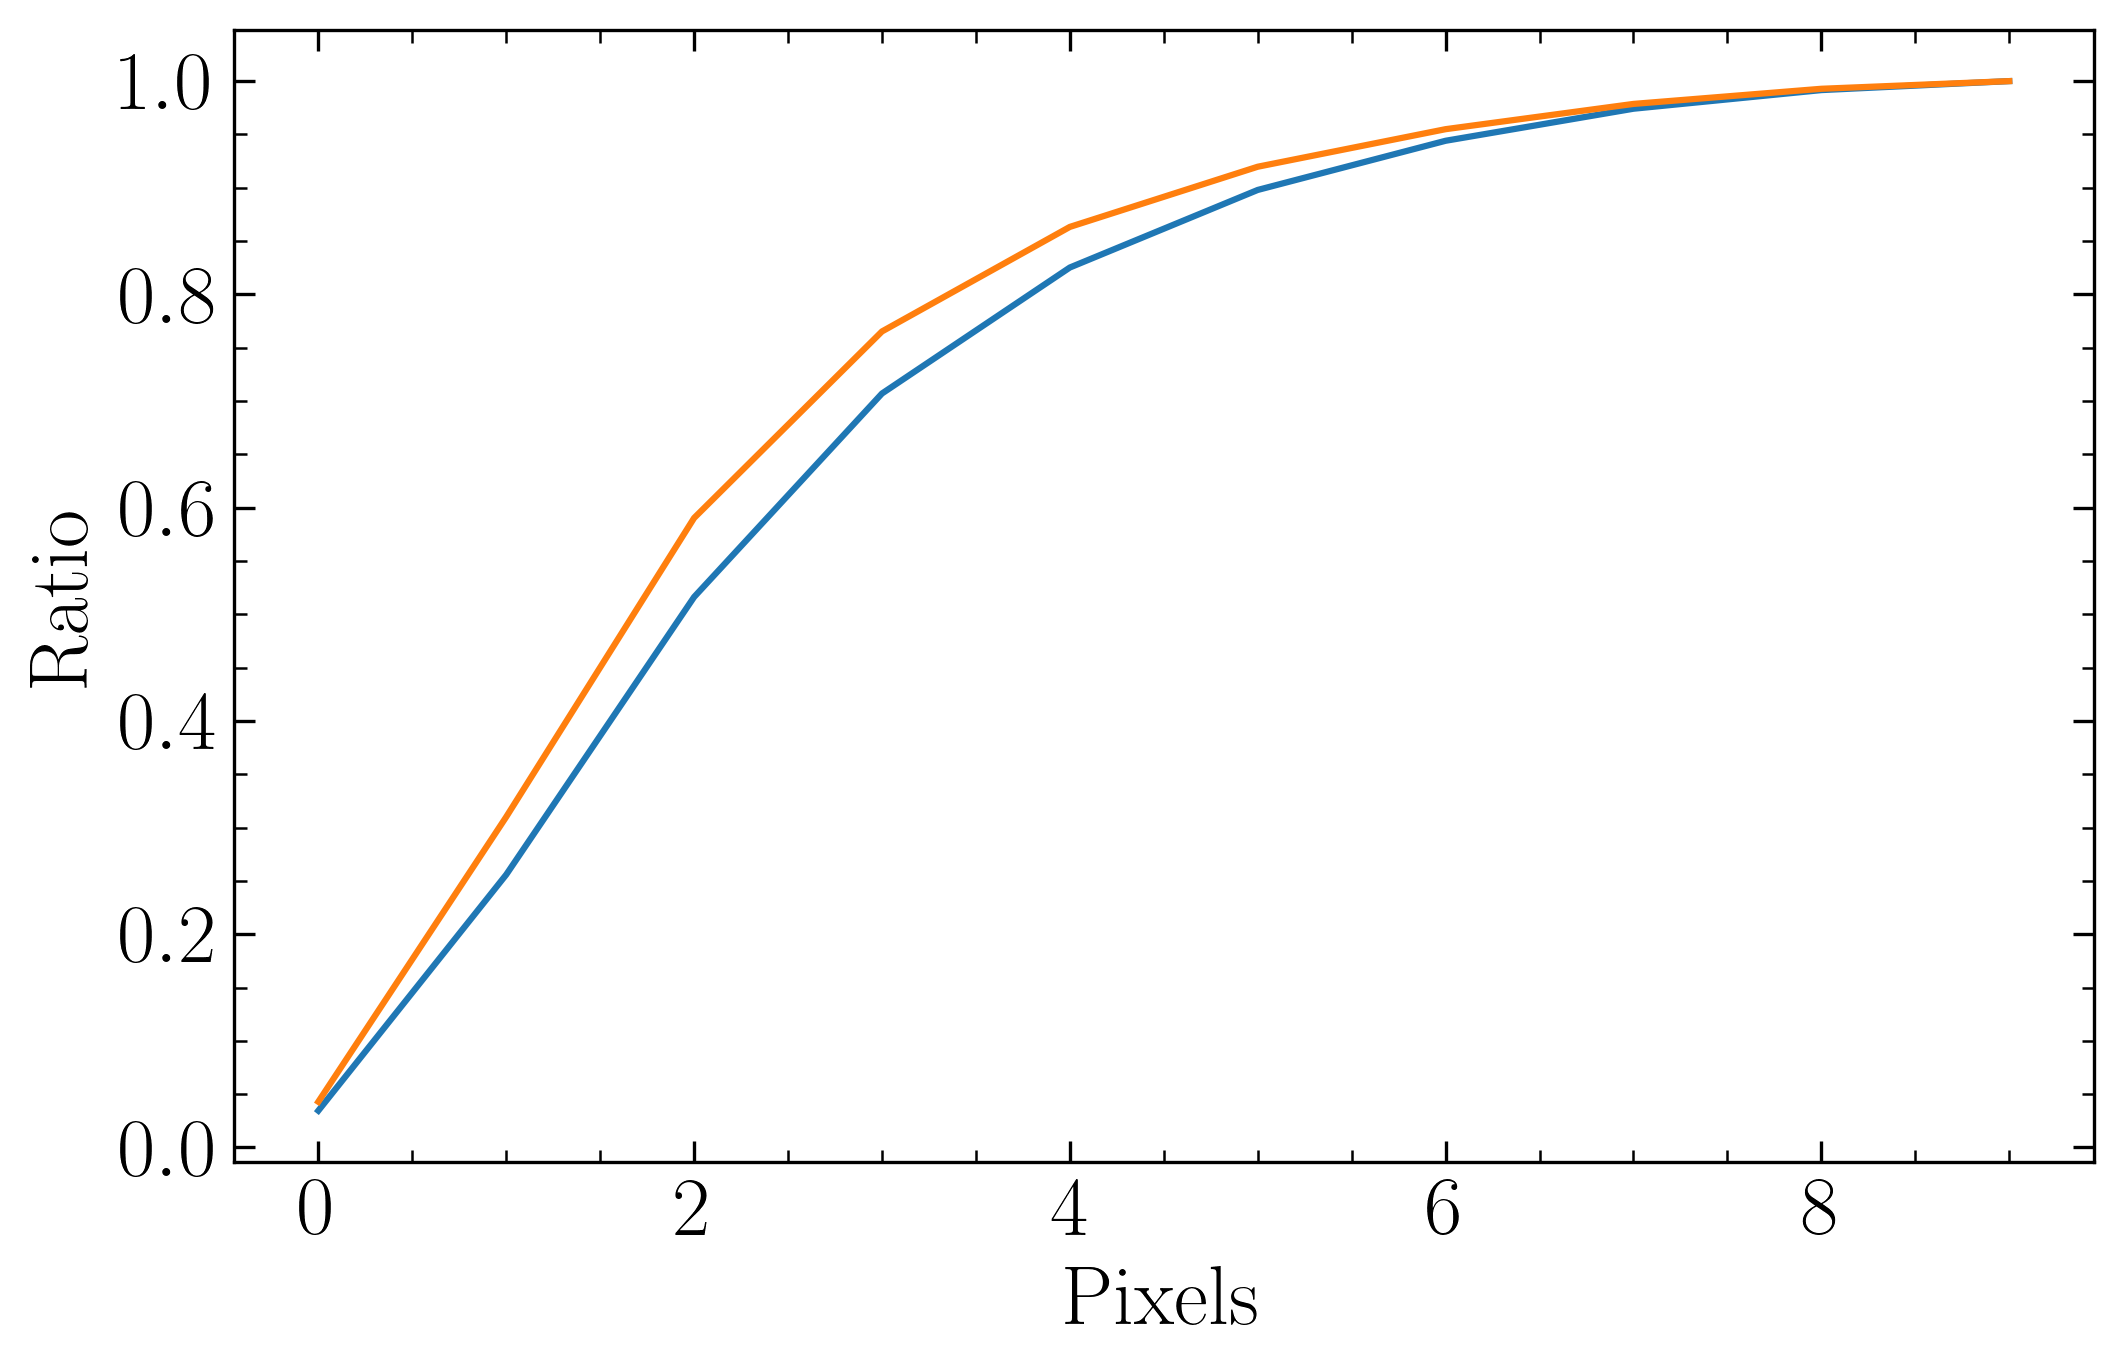

In [3]:

# EE Curve
EE_ape = cube.subcube_circle_aperture((p, q), 10, unit_center=None, unit_radius=None)
source_100 = EE_ape[350, :, :]  # change to wavelength instead of index
radius_100, ee_100 = source_100.eer_curve(unit_center=None, unit_radius=None)
source_200 = EE_ape[3000, :, :]
radius_200, ee_200 = source_200.eer_curve(unit_center=None, unit_radius=None)

# Make the EE plot
plt.figure(figsize=(8, 5), dpi=300)
plt.plot(radius_100, ee_100)
plt.plot(radius_200, ee_200)
plt.xlabel(r'$\mathrm{Pixels}$', size=20)
plt.ylabel(r'$\mathrm{Ratio}$', size=20)
plt.minorticks_on()
plt.tick_params(axis='both', which='major', direction='in', top='on', bottom='on', left='on', right='on',
                labelsize=20, size=5)
plt.tick_params(axis='both', which='minor', direction='in', top='on', bottom='on', left='on', right='on',
                size=3)

In [4]:
# cube_ape.plot()
# plt.plot(cube_ape.wave.coord(),np.sqrt(cube_ape.var))
# print(np.sqrt(cube_ape.var))

[INFO] 16 spaxels used


0.005202969044432456


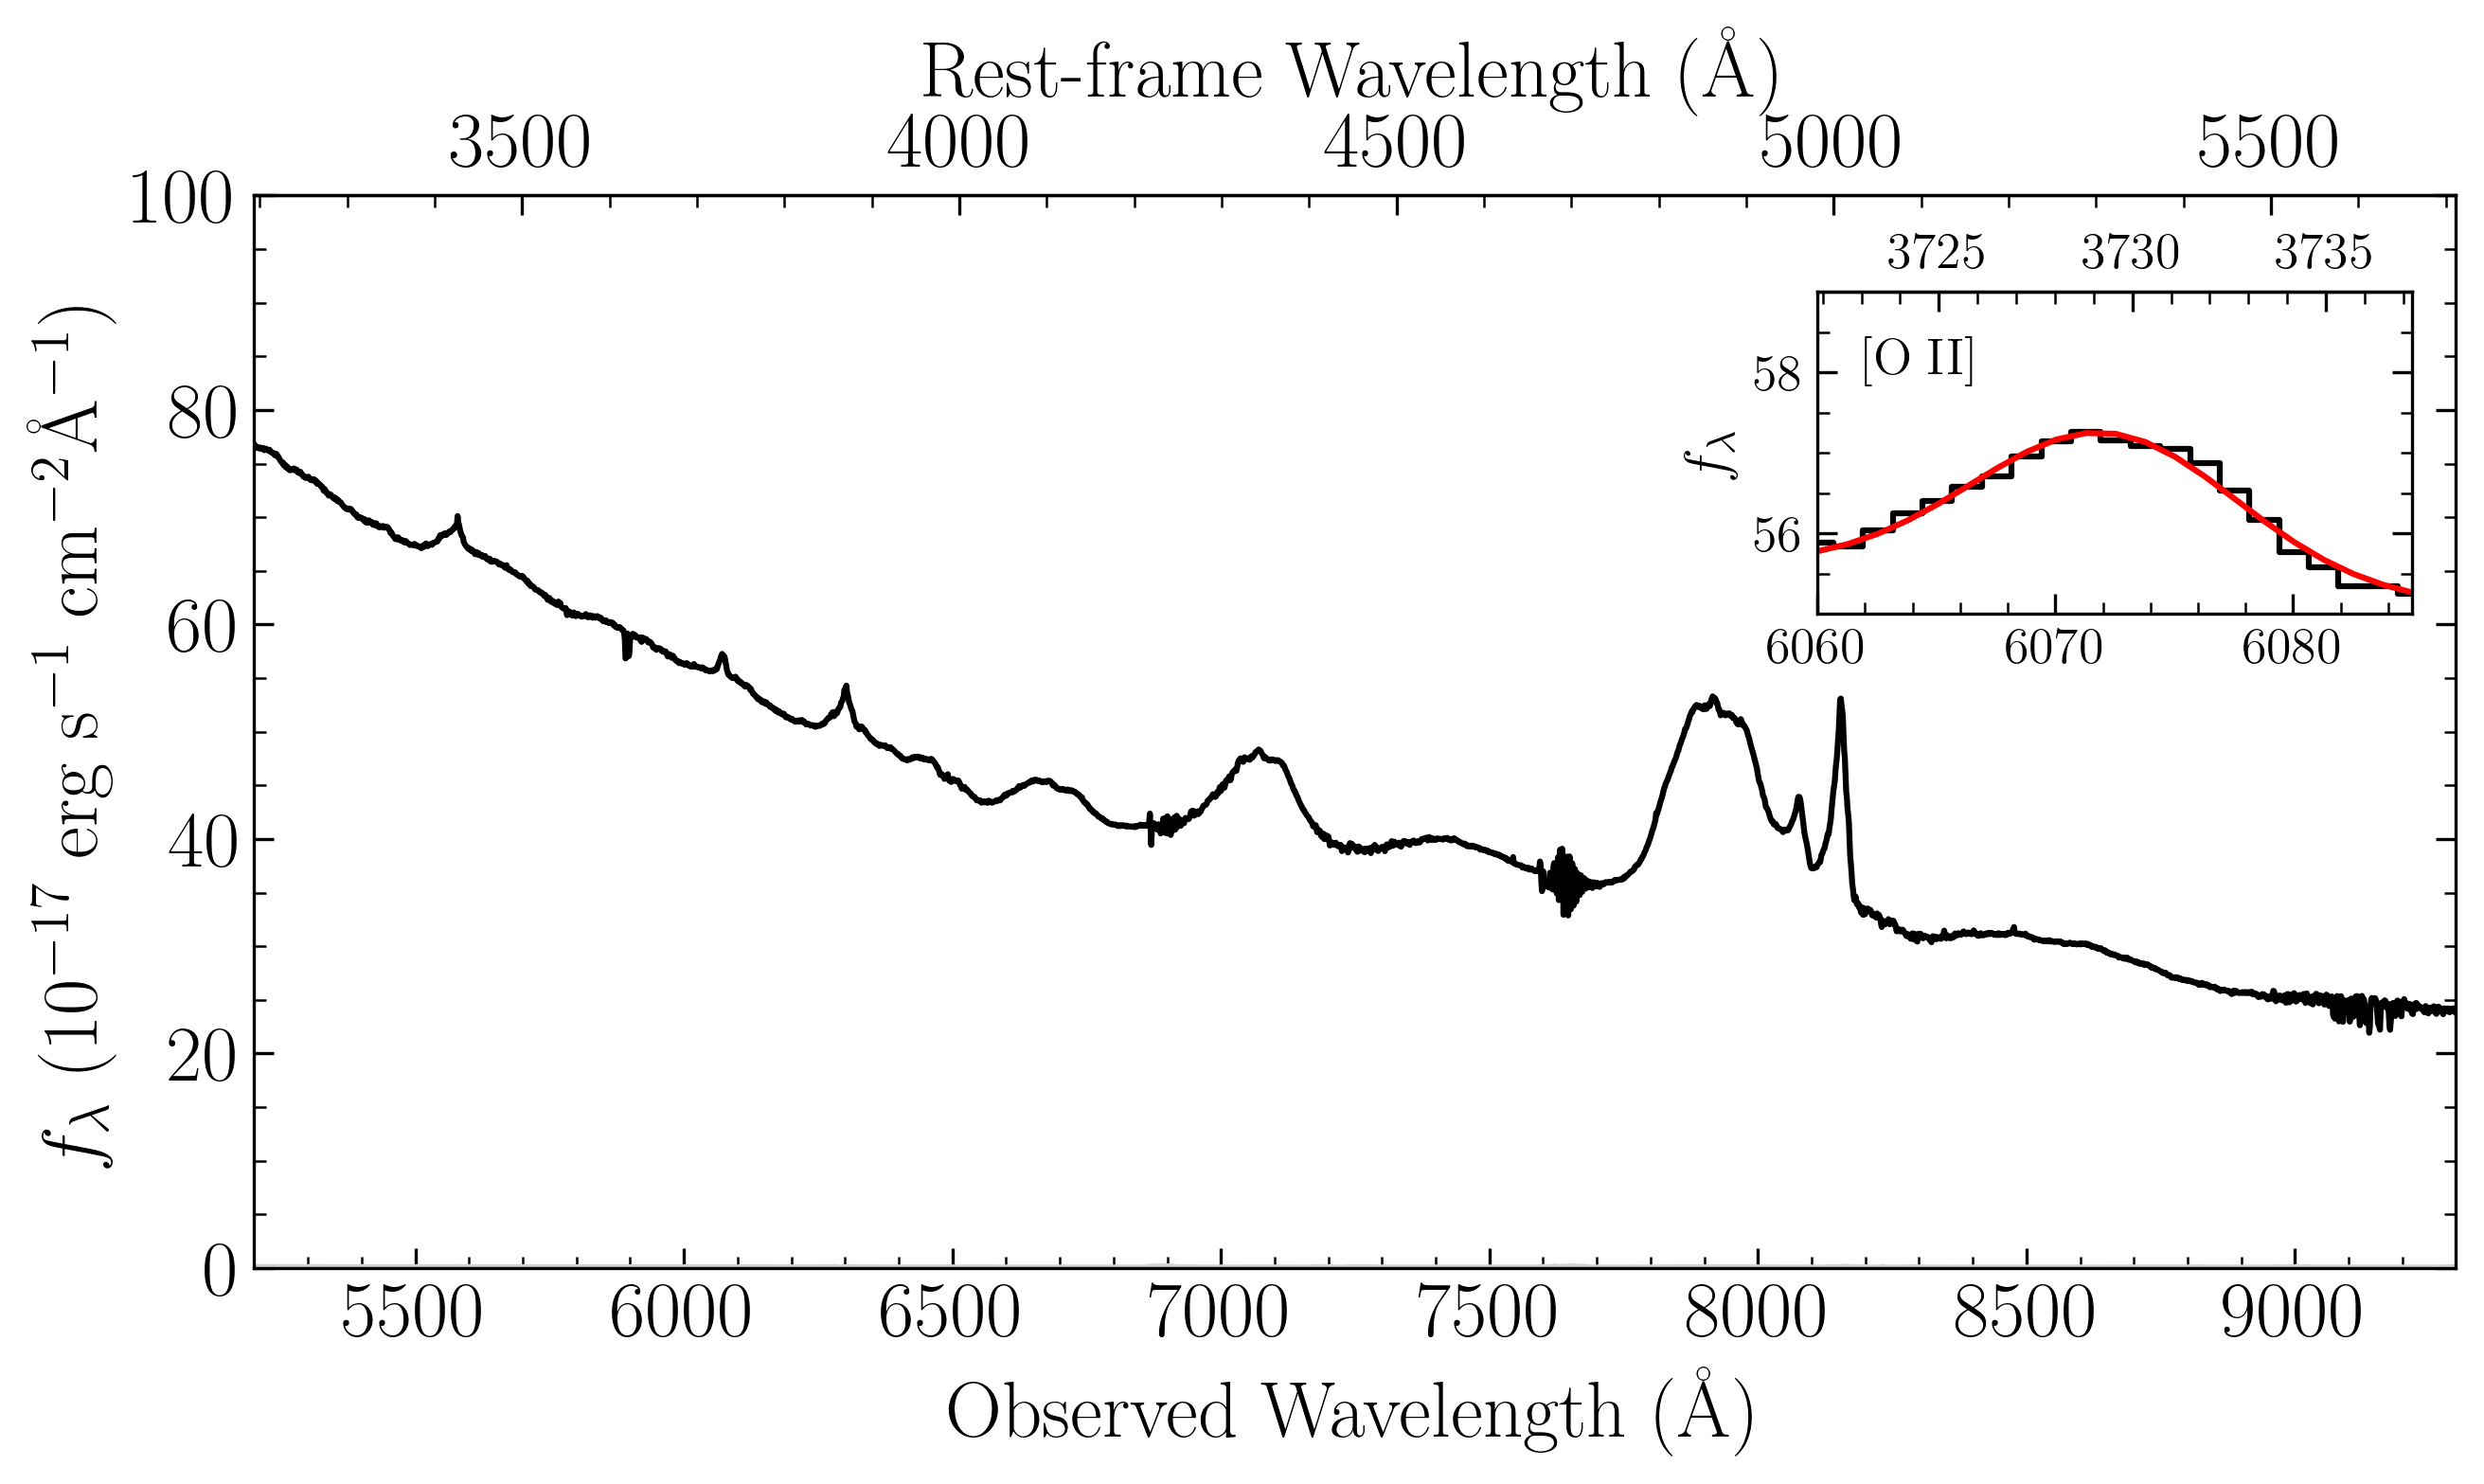

In [5]:

# Spectrum
cube_ape = cube.aperture((p, q), 2, unit_center=None, unit_radius=None, is_sum=True)

wave_vac = pyasl.airtovac2(cube_ape.wave.coord())
# convert air wavelength to vacuum 2. measure the redshift (OII doublet emission line)
# 3. luminosity and the line width of Hbeta
flux = cube_ape.data * 1e-3
flux_err = np.sqrt(cube_ape.var) * 1e-3

print((np.sqrt(cube_ape.var) / cube_ape.data).max())

# Fitting the redshift
wave_OII3727_vac = 3727.092
wave_OII3729_vac = 3729.875
c_kms = 2.998e5

OII_region = np.where((wave_vac > 6050) * (wave_vac < 6100))
wave_OII_vac = wave_vac[OII_region]
flux_OII = flux[OII_region]


# Define a function with the MUSE resolution
def getFWHM_MUSE(wave):
    return (5.866e-8 * wave ** 2 - 9.187e-4 * wave + 6.04)


# Define a function with the MUSE resolution
def getSigma_MUSE(wave):
    return (5.866e-8 * wave ** 2 - 9.187e-4 * wave + 6.04) / 2.355


# Define the model fit function
def model(wave_vac, z, sigma_kms, fluxOII, rOII3729_3727, a, b):
    wave_OII3727_obs = wave_OII3727_vac * (1 + z)
    wave_OII3729_obs = wave_OII3729_vac * (1 + z)

    sigma_OII3727_A = np.sqrt((sigma_kms / c_kms * wave_OII3727_obs) ** 2 + (getSigma_MUSE(wave_OII3727_obs)) ** 2)
    sigma_OII3729_A = np.sqrt((sigma_kms / c_kms * wave_OII3729_obs) ** 2 + (getSigma_MUSE(wave_OII3729_obs)) ** 2)

    # sigma_OII3727_A = sigma_kms / c_kms * wave_OII3727_obs
    # sigma_OII3729_A = sigma_kms / c_kms * wave_OII3729_obs

    fluxOII3727 = fluxOII / (1 + rOII3729_3727)
    fluxOII3729 = fluxOII / (1 + 1.0 / rOII3729_3727)

    peakOII3727 = fluxOII3727 / np.sqrt(2 * sigma_OII3727_A ** 2 * np.pi)
    peakOII3729 = fluxOII3729 / np.sqrt(2 * sigma_OII3729_A ** 2 * np.pi)

    OII3727_gaussian = peakOII3727 * np.exp(-(wave_vac - wave_OII3727_obs) ** 2 / 2 / sigma_OII3727_A ** 2)
    OII3729_gaussian = peakOII3729 * np.exp(-(wave_vac - wave_OII3729_obs) ** 2 / 2 / sigma_OII3729_A ** 2)

    return OII3727_gaussian + OII3729_gaussian + a * wave_vac + b


redshift_guess = 0.63
sigma_kms_guess = 150.0
flux_OII_guess = 42
rOII3729_3727_guess = 100

parameters = lmfit.Parameters()
parameters.add_many(('z', redshift_guess, True, None, None, None),
                    ('sigma_kms', sigma_kms_guess, True, 10.0, 500.0, None),
                    ('fluxOII', flux_OII_guess, True, None, None, None),
                    ('rOII3729_3727', rOII3729_3727_guess, True, 0, 3, None),
                    ('a', 0.0, True, None, None, None),
                    ('b', 100, True, None, None, None))
spec_model = lmfit.Model(model, missing='drop')
result = spec_model.fit(flux_OII, wave_vac=wave_OII_vac, params=parameters)
# print('Success = {}'.format(result.success))
# print(result.fit_report())
z = result.best_values['z']


def rest2obs(x):
    return x * (1 + z)


def obs2rest(x):
    return x / (1 + z)


# Plot the Spectrum
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=300)
ax.plot(wave_vac, flux, color='k')
ax.plot(wave_vac, flux_err, color='lightgrey')
ax.set_xlim(5200, 9300)
ax.set_ylim(0, 100)
ax.set_xlabel(r'$\mathrm{Observed \; Wavelength \; (\AA)}$', size=20)
ax.set_ylabel(r'${f}_{\lambda} \; (10^{-17} \; \mathrm{erg \; s^{-1} \; cm^{-2} \AA^{-1}})$', size=20)

secax = ax.secondary_xaxis('top', functions=(obs2rest, rest2obs))
secax.minorticks_on()
secax.set_xlabel(r'$\mathrm{Rest \mbox{-} frame \; Wavelength \; (\AA)}$', size=20)
secax.tick_params(axis='x', which='major', direction='in', top='on', size=5, labelsize=20)
secax.tick_params(axis='x', which='minor', direction='in', top='on', size=3)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', direction='in', bottom='on', left='on', right='on', labelsize=20, size=5)
ax.tick_params(axis='both', which='minor', direction='in', bottom='on', left='on', right='on', size=3)

axins = ax.inset_axes([0.71, 0.61, 0.27, 0.3])
axins.plot(wave_OII_vac, flux_OII, color='black', drawstyle='steps-mid')
axins.plot(wave_OII_vac, result.best_fit, color='red')
axins.set_xlim(6060, 6085)
axins.set_ylim(55, 59)
axins.set_ylabel(r'${f}_{\lambda}$', size=15)
axins.text(6062, 58, r'$\mathrm{[O\;II]}$', size=13)
axins.minorticks_on()
axins.tick_params(axis='both', which='major', direction='in', bottom='on', left='on', right='on',
                  labelsize=13, size=5)
axins.tick_params(axis='both', which='minor', direction='in', bottom='on', left='on', right='on',
                  size=3)

secaxins = axins.secondary_xaxis('top', functions=(obs2rest, rest2obs))
secaxins.minorticks_on()
secaxins.tick_params(axis='x', which='major', direction='in', top='on', size=5, labelsize=13)
secaxins.tick_params(axis='x', which='minor', direction='in', top='on', size=3)
# plt.savefig('/Users/lzq/Dropbox/qso_cgm/qso_spectrum_new',  bbox_inches='tight')

In [6]:
from scipy import interpolate
# Iron and continuum fitting
cont_region_1 = np.where((wave_vac / (1 + z)  > 4435) * (wave_vac / (1 + z) < 4600))
wave_contr1_vac = wave_vac[cont_region_1]
wave_contr1_rest = wave_contr1_vac / (1 + z)
flux_contr1 = flux[cont_region_1]

cont_region_2 = np.where((wave_vac / (1 + z) > 5100) * (wave_vac / (1 + z) < 5535))
wave_contr2_vac = wave_vac[cont_region_2]
wave_contr2_rest = wave_contr2_vac / (1 + z)
flux_contr2 = flux[cont_region_2]

wave_cont_vac = np.hstack((wave_contr1_vac, wave_contr2_vac))
flux_cont = np.hstack((flux_contr1, flux_contr2))

wave_cont_rest = wave_cont_vac / (1 + z)
flux_cont_rest = flux_cont * (1 + z)

Hbeta_region = np.where((wave_vac / (1 + z)  > 4600) * (wave_vac / (1 + z) < 5100))
wave_Hbeta_vac = wave_vac[Hbeta_region]
wave_Hbeta_rest = wave_vac[Hbeta_region] / (1 + z)
#wave_Hbeta = wave_vac[Hbeta_region]


path = '/Users/lzq/Dropbox/Data/CGM/'
fe_uv = np.genfromtxt(path + 'fe_uv.txt')
fe_op = np.genfromtxt(path + 'fe_optical.txt')

def Fe_flux_balmer(xval, p1, p2, p3):
    "Fit the optical FeII on the continuum from 3686 to 7484 A based on Vestergaard & Wilkes 2001"
    yval = np.zeros_like(xval)
    wave_Fe_balmer = 10 ** fe_op[:, 0]
    flux_Fe_balmer = fe_op[:, 1] / 1e-17
    
    
    ind = np.where((wave_Fe_balmer > 3686.) & (wave_Fe_balmer < 7484.), True, False)
    wave_Fe_balmer = wave_Fe_balmer[ind]
    flux_Fe_balmer = flux_Fe_balmer[ind]
    Fe_FWHM = p2


    xval_new = xval * (1.0 + p3)
    ind = np.where((xval_new > 3686.) & (xval_new < 7484.), True, False)

    sig_conv = np.sqrt(Fe_FWHM ** 2 - 900.0 ** 2) / 2. / np.sqrt(2. * np.log(2.))  # in km/s
    
    # Get sigma in pixel space
    sig_pix = sig_conv / 106.3  # 106.3 km/s is the dispersion for the BG92 FeII template

    khalfsz = np.round(4 * sig_pix + 1, 0)
    xx = np.arange(0, khalfsz * 2, 1) - khalfsz
    kernel = np.exp(-xx ** 2 / (2 * sig_pix ** 2))
    kernel = kernel / np.sum(kernel)

    flux_Fe_conv = np.convolve(flux_Fe_balmer, kernel, 'same')
    tck = interpolate.splrep(wave_Fe_balmer, flux_Fe_conv)
    yval[ind] = p1 * interpolate.splev(xval_new[ind], tck)
    return yval


def continuum(wave_rest, p1, p2, p3, p4, p5):
    return Fe_flux_balmer(wave_rest, p1, p2, p3) + p4 * (wave_rest / 3000) ** p5


p1_guess = 0.2
p2_guess = 3000
p3_guess = 0.02
p4_guess = 0.8
p5_guess = -1

parameters1 = lmfit.Parameters()
parameters1.add_many(('p1', p1_guess, True, 0, 1e10, None),
                     ('p2', p2_guess, True, 1200, 10000, None),
                     ('p3', p3_guess, True, -1, 1, None),
                     ('p4', p4_guess, True, 0, 1e10, None),
                     ('p5', p4_guess, True, -5, 3, None))
spec_model1 = lmfit.Model(continuum, missing='drop')
result1 = spec_model1.fit(flux_cont_rest, wave_rest=wave_cont_rest, params=parameters1)
# print('Success = {}'.format(result.success))
print(result1.fit_report())

p1 = result1.best_values['p1']
p2 = result1.best_values['p2']
p3 = result1.best_values['p3']
p4 = result1.best_values['p4']
p5 = result1.best_values['p5']

[[Model]]
    Model(continuum)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 63
    # data points      = 782
    # variables        = 5
    chi-square         = 246.914440
    reduced chi-square = 0.31777920
    Akaike info crit   = -891.499656
    Bayesian info crit = -868.190382
[[Variables]]
    p1:  0.05754563 +/- 9.6631e-04 (1.68%) (init = 0.2)
    p2:  6623.83815 +/- 203.139773 (3.07%) (init = 3000)
    p3:  0.00322031 +/- 1.6513e-04 (5.13%) (init = 0.02)
    p4:  104.906452 +/- 0.68538732 (0.65%) (init = 0.8)
    p5: -1.63474421 +/- 0.00892786 (0.55%) (init = 0.8)
[[Correlations]] (unreported correlations are < 0.100)
    C(p4, p5) = -0.962
    C(p1, p4) = -0.861
    C(p1, p5) =  0.699
    C(p1, p2) =  0.664
    C(p2, p4) = -0.450
    C(p3, p5) =  0.351
    C(p2, p5) =  0.326
    C(p3, p4) = -0.252
    C(p2, p3) = -0.114


In [7]:
print(z)

0.6282144177077355


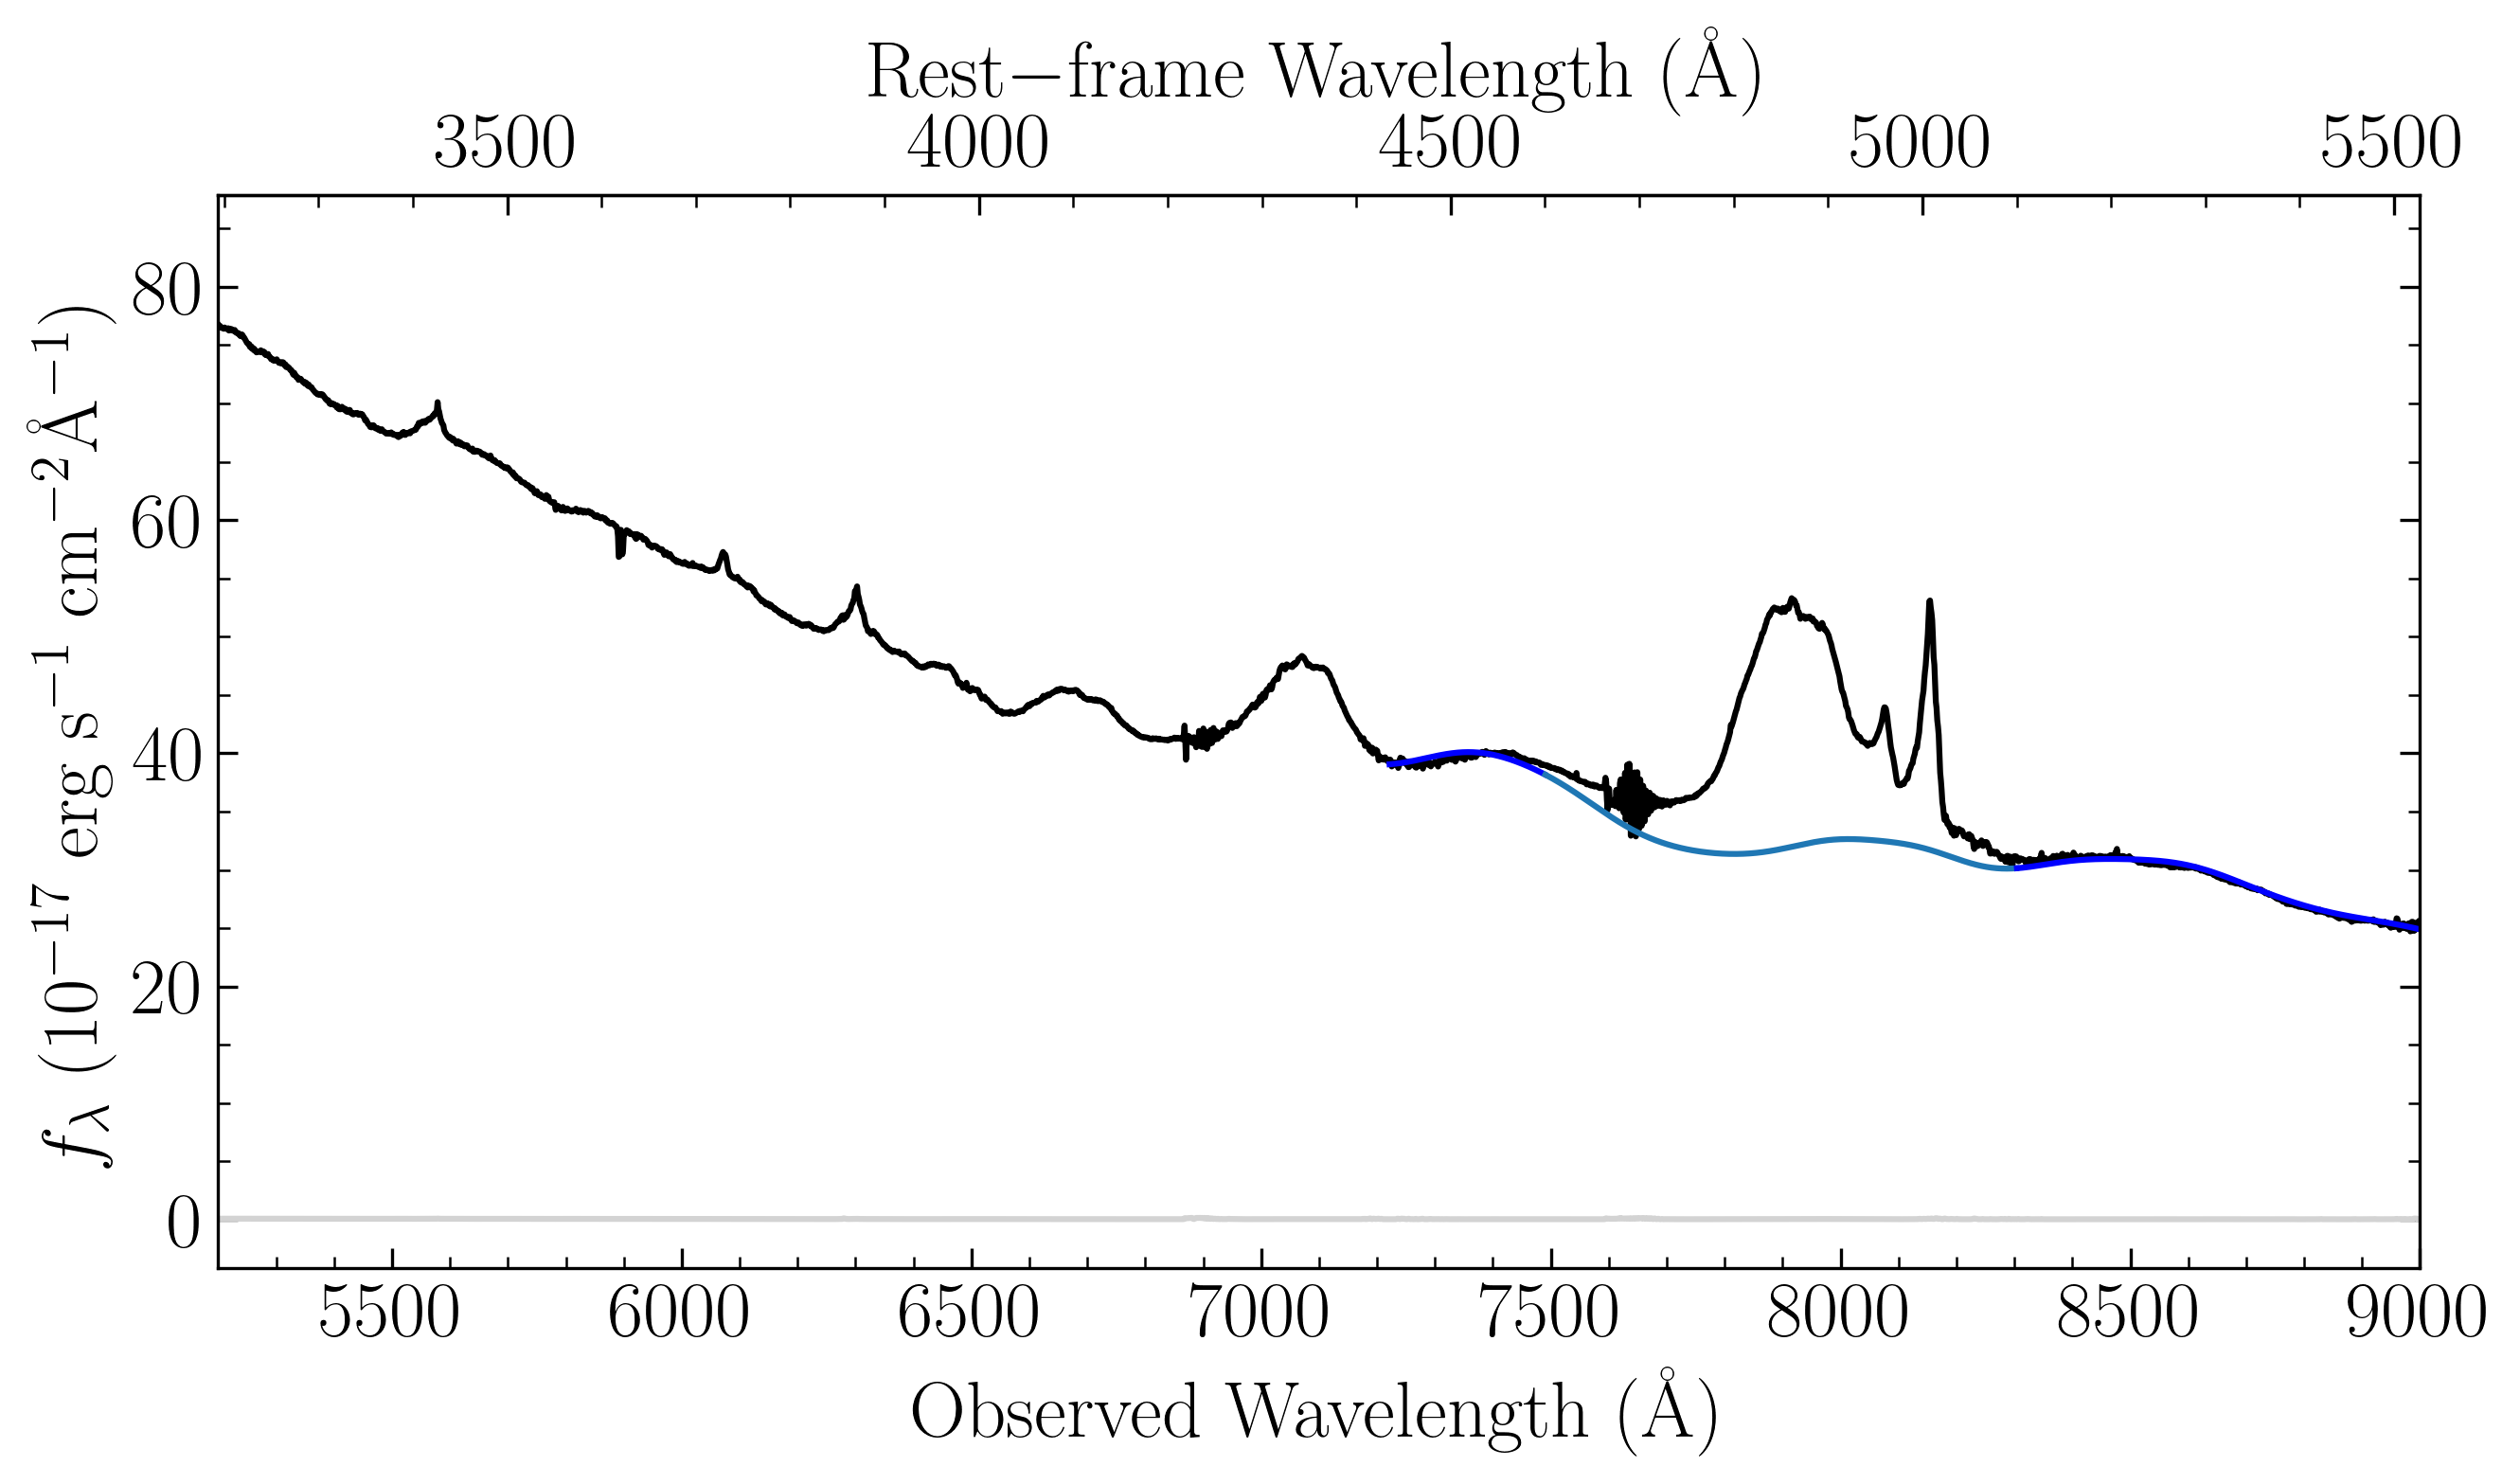

In [8]:
# Plot the Spectrum
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=300)
ax.plot(wave_vac, flux, color='k')
ax.plot(wave_contr1_vac, continuum(wave_contr1_rest, p1, p2, p3, p4, p5) / (1 + z), '-b')
ax.plot(wave_Hbeta_vac, continuum(wave_Hbeta_rest, p1, p2, p3, p4, p5) / (1 + z), '-')
ax.plot(wave_contr2_vac, continuum(wave_contr2_rest, p1, p2, p3, p4, p5) / (1 + z), '-b')
ax.plot(wave_vac, flux_err, color='lightgrey')
ax.set_xlim(5200, 9000)
#ax.set_ylim(20, 55)
ax.set_xlabel(r'$\mathrm{Observed \; Wavelength \; (\AA)}$', size=20)
ax.set_ylabel(r'${f}_{\lambda} \; (10^{-17} \; \mathrm{erg \; s^{-1} \; cm^{-2} \AA^{-1}})$', size=20)

secax = ax.secondary_xaxis('top', functions=(obs2rest, rest2obs))
secax.minorticks_on()
secax.set_xlabel(r'$\mathrm{Rest \mathrm{-} frame \; Wavelength \; (\AA)}$', size=20)
secax.tick_params(axis='x', which='major', direction='in', top='on', size=5, labelsize=20)
secax.tick_params(axis='x', which='minor', direction='in', top='on', size=3)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', direction='in', bottom='on', left='on', right='on', labelsize=20, size=5)
ax.tick_params(axis='both', which='minor', direction='in', bottom='on', left='on', right='on', size=3)

# axins = ax.inset_axes([0.71, 0.61, 0.27, 0.3])
# axins.plot(wave_OII_vac, flux_OII, color='black', drawstyle='steps-mid')
# axins.plot(wave_OII_vac, result.best_fit, color='red')
# axins.set_xlim(6060, 6085)
# axins.set_ylim(55, 59)
# axins.set_ylabel(r'${f}_{\lambda}$', size=15)
# axins.text(6062, 58, r'$\mathrm{[O\;II]}$', size=13)
# axins.minorticks_on()
# axins.tick_params(axis='both', which='major', direction='in', bottom='on', left='on', right='on',
#                   labelsize=13, size=5)
# axins.tick_params(axis='both', which='minor', direction='in', bottom='on', left='on', right='on',
#                   size=3)

# secaxins = axins.secondary_xaxis('top', functions=(obs2rest, rest2obs))
# secaxins.minorticks_on()
# secaxins.tick_params(axis='x', which='major', direction='in', top='on', size=5, labelsize=13)
# secaxins.tick_params(axis='x', which='minor', direction='in', top='on', size=3)
# plt.savefig('/Users/lzq/Dropbox/qso_cgm/qso_spectrum_new',  bbox_inches='tight')

In [9]:
%matplotlib inline
import glob, os, sys, timeit
import matplotlib
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
sys.path.append('/Users/lzq/Dropbox/PyQSOFit')
from PyQSOFit import QSOFit

path='../PyQSOFit/'


newdata = np.rec.array([(6564.61, 'Ha', 6400., 6800., 'Ha_br', 3, 5e-3, 0.004, 0.05, 0.015, 0, 0, 0, 0.05), \
                        # (6564.61, 'Ha', 6400., 6800., 'Ha_na', 1, 1e-3, 5e-4, 0.0017, 0.01, 1, 1, 0, 0.002),\
                        # (6549.85, 'Ha', 6400., 6800., 'NII6549', 1, 1e-3, 2.3e-4, 0.0017, 5e-3, 1, 1, 1, 0.001),\
                        # (6585.28, 'Ha', 6400., 6800., 'NII6585', 1, 1e-3, 2.3e-4, 0.0017, 5e-3, 1, 1, 1, 0.003),\
                        # (6718.29, 'Ha', 6400., 6800., 'SII6718', 1, 1e-3, 2.3e-4, 0.0017, 5e-3, 1, 1, 2, 0.001),\
                        # (6732.67, 'Ha', 6400., 6800., 'SII6732', 1, 1e-3, 2.3e-4, 0.0017, 5e-3, 1, 1, 2, 0.001),\

                        (4862.68, 'Hb', 4640., 5100., 'Hb_br', 3, 5e-3, 0.004, 0.05, 0.01, 0, 0, 0, 0.01), \
                        (4862.68, 'Hb', 4640., 5100., 'Hb_na', 2, 1e-3, 2.3e-4, 0.0016, 0.01, 1, 1, 0, 0.002), \
                        (4960.30, 'Hb', 4640., 5100., 'OIII4960c', 2, 1e-3, 2.3e-4, 0.0016, 0.01, 1, 1, 0, 0.002), \
                        (5008.24, 'Hb', 4640., 5100., 'OIII5008c', 2, 1e-3, 2.3e-4, 0.0016, 0.01, 1, 1, 0, 0.004), \
                        # (4960.30, 'Hb', 4640., 5100., 'OIII4959w', 1,3e-3, 2.3e-4, 0.004, 0.01, 2, 2, 0, 0.001),\
                        # (5008.24, 'Hb', 4640., 5100., 'OIII5007w', 1,3e-3, 2.3e-4, 0.004, 0.01, 2, 2, 0, 0.002),\
                        # (4687.02, 'Hb', 4640., 5100., 'HeII4687_br', 1,5e-3, 0.004, 0.05, 0.005, 0, 0, 0, 0.001),\
                        # (4687.02, 'Hb', 4640., 5100., 'HeII4687_na', 1,1e-3, 2.3e-4, 0.0017, 0.005, 1, 1, 0, 0.001),\

                        # (3934.78, 'CaII', 3900., 3960., 'CaII3934', 2, 1e-3, 3.333e-4, 0.0017, 0.01, 99, 0, 0, -0.001),\
                        #
                        # (3728.48, 'OII', 3650., 3800., 'OII3728', 1, 1e-3, 3.333e-4, 0.0017, 0.01, 1, 1, 0, 0.001),\
                        #
                        # (3426.84, 'NeV', 3380., 3480., 'NeV3426', 1, 1e-3, 3.333e-4, 0.0017, 0.01, 0, 0, 0, 0.001),\
                        # (3426.84, 'NeV', 3380., 3480., 'NeV3426_br', 1, 5e-3, 0.0025, 0.02, 0.01, 0, 0, 0, 0.001),\


                        (2798.75, 'MgII', 2700., 2900., 'MgII_br', 1, 5e-3, 0.004, 0.05, 0.0017, 0, 0, 0, 0.05), \
                        (2798.75, 'MgII', 2700., 2900., 'MgII_na', 2, 1e-3, 5e-4, 0.0017, 0.01, 1, 1, 0, 0.002), \

                        (1908.73, 'CIII', 1700., 1970., 'CIII_br', 2, 5e-3, 0.004, 0.05, 0.015, 99, 0, 0, 0.01), \
                        # (1908.73, 'CIII', 1700., 1970., 'CIII_na', 1, 1e-3, 5e-4, 0.0017, 0.01, 1, 1, 0, 0.002), \
                        # (1892.03, 'CIII', 1700., 1970., 'SiIII1892', 1, 2e-3, 0.001, 0.015, 0.003, 1, 1, 0, 0.005), \
                        # (1857.40, 'CIII', 1700., 1970., 'AlIII1857', 1, 2e-3, 0.001, 0.015, 0.003, 1, 1, 0, 0.005), \
                        # (1816.98, 'CIII', 1700., 1970., 'SiII1816', 1, 2e-3, 0.001, 0.015, 0.01, 1, 1, 0, 0.0002), \
                        # (1786.7, 'CIII', 1700., 1970., 'FeII1787', 1, 2e-3, 0.001, 0.015, 0.01, 1, 1, 0, 0.0002), \
                        # (1750.26, 'CIII', 1700., 1970., 'NIII1750', 1, 2e-3, 0.001, 0.015, 0.01, 1, 1, 0, 0.001), \
                        # (1718.55, 'CIII', 1700., 1900., 'NIV1718', 1, 2e-3, 0.001, 0.015, 0.01, 1, 1, 0, 0.001),\

                        (1549.06, 'CIV', 1500., 1700., 'CIV_br', 1, 5e-3, 0.004, 0.05, 0.015, 0, 0, 0, 0.05), \
                        (1549.06, 'CIV', 1500., 1700., 'CIV_na', 1, 1e-3, 5e-4, 0.0017, 0.01, 1, 1, 0, 0.002), \
                        (1640.42, 'CIV', 1500., 1700., 'HeII1640', 1, 1e-3, 5e-4, 0.0017, 0.008, 1, 1, 0, 0.002), \
                        (1663.48, 'CIV', 1500., 1700., 'OIII1663', 1, 1e-3, 5e-4, 0.0017, 0.008, 1, 1, 0, 0.002), \
                        (1640.42, 'CIV', 1500., 1700., 'HeII1640_br', 1, 5e-3, 0.0025, 0.02, 0.008, 1, 1, 0, 0.002), \
                        (1663.48, 'CIV', 1500., 1700., 'OIII1663_br', 1, 5e-3, 0.0025, 0.02, 0.008, 1, 1, 0, 0.002), \

                        # (1402.06, 'SiIV', 1290., 1450., 'SiIV_OIV1', 1, 5e-3, 0.002, 0.05, 0.015, 1, 1, 0, 0.05), \
                        # (1396.76, 'SiIV', 1290., 1450., 'SiIV_OIV2', 1, 5e-3, 0.002, 0.05, 0.015, 1, 1, 0, 0.05), \
                        # (1335.30, 'SiIV', 1290., 1450., 'CII1335', 1, 2e-3, 0.001, 0.015, 0.01, 1, 1, 0, 0.001), \
                        # (1304.35, 'SiIV', 1290., 1450., 'OI1304', 1, 2e-3, 0.001, 0.015, 0.01, 1, 1, 0, 0.001), \

                        (1215.67, 'Lya', 1150., 1290., 'Lya_br', 1, 5e-3, 0.004, 0.05, 0.02, 0, 0, 0, 0.05), \
                        (1215.67, 'Lya', 1150., 1290., 'Lya_na', 1, 1e-3, 5e-4, 0.0017, 0.01, 0, 0, 0, 0.002) \
                        ], \
                       formats='float32, a20, float32, float32, a20, float32, float32, float32, float32, float32, '
                               'float32, float32, float32, float32', \
                       names='lambda, compname, minwav, maxwav, linename, ngauss, inisig, minsig, maxsig, voff, '
                             'vindex, windex, findex, fvalue')
hdr = fits.Header()
hdr['lambda'] = 'Vacuum Wavelength in Ang'
hdr['minwav'] = 'Lower complex fitting wavelength range'
hdr['maxwav'] = 'Upper complex fitting wavelength range'
hdr['ngauss'] = 'Number of Gaussians for the line'
hdr['inisig'] = 'Initial guess of linesigma [in lnlambda]'
hdr['minsig'] = 'Lower range of line sigma [lnlambda]'  
hdr['maxsig'] = 'Upper range of line sigma [lnlambda]'
hdr['voff  '] = 'Limits on velocity offset from the central wavelength [lnlambda]'
hdr['vindex'] = 'Entries w/ same NONZERO vindex constrained to have same velocity'
hdr['windex'] = 'Entries w/ same NONZERO windex constrained to have same width'
hdr['findex'] = 'Entries w/ same NONZERO findex have constrained flux ratios'
hdr['fvalue'] = 'Relative scale factor for entries w/ same findex'


#------save line info-----------
hdu = fits.BinTableHDU(data=newdata, header=hdr, name='data')
hdu.writeto(path + 'qsopar.fits', overwrite=True)

In [10]:
path1 = path             # the path of the source code file and qsopar.fits
path2 = '../qso_cgm/data/result/' # path of fitting results
path3 = '../qso_cgm/data/QA_result/'   # path of figure
path4 = '../PyQSOFit/sfddata/'             # path of dust reddening map

#Requried
# an important note that all the data input must be finite, especically for the error !!!
lam_qsofit = wave_vac       # OBS wavelength [A]
flux_qsofit = flux     # OBS flux [erg/s/cm^2/A]
flux_err_qsofit = flux_err # 1 sigma error

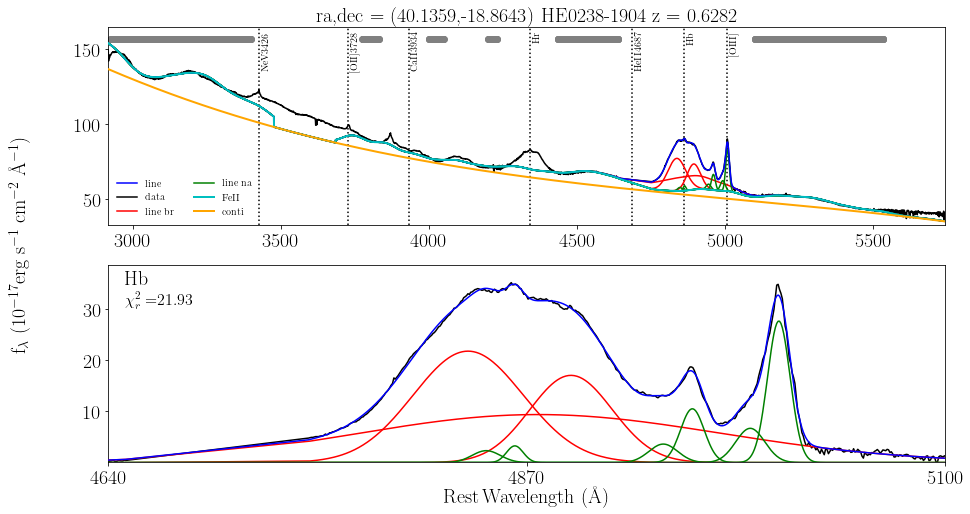

In [11]:
# get data prepared 
q = QSOFit(lam_qsofit, flux_qsofit, flux_err_qsofit, z, ra=40.1359, dec=-18.8643, plateid=0, mjd=0, fiberid=0, path=path1)

# do the fitting
q.Fit(name='HE0238-1904', nsmooth=1, and_or_mask=False, deredden=True, reject_badpix = False, wave_range = None,\
      wave_mask=np.array([[4650, 4750]]), decomposition_host=False, Mi=None, npca_gal = 5, npca_qso = 20, \
      Fe_uv_op=True, Fe_flux_range=np.array([4435,4685]), poly=True, BC = False, rej_abs = False, \
      initial_guess=None, MC=False, n_trails=5, linefit=True, tie_lambda = True, tie_width = True, \
      tie_flux_1 = True, tie_flux_2 = True, save_result = True, plot_fig = True, save_fig = True, \
      plot_line_name = True, plot_legend = True, dustmap_path = path4, save_fig_path = path3, \
      save_fits_path = path2, save_fits_name='qso_fittings')

optical Fe flux (10^(-17) erg/s/cm^2): 1791.9804000881668
Fe flux within a specific range: 
Fe_flux_4400_4900: 2456.344681226861


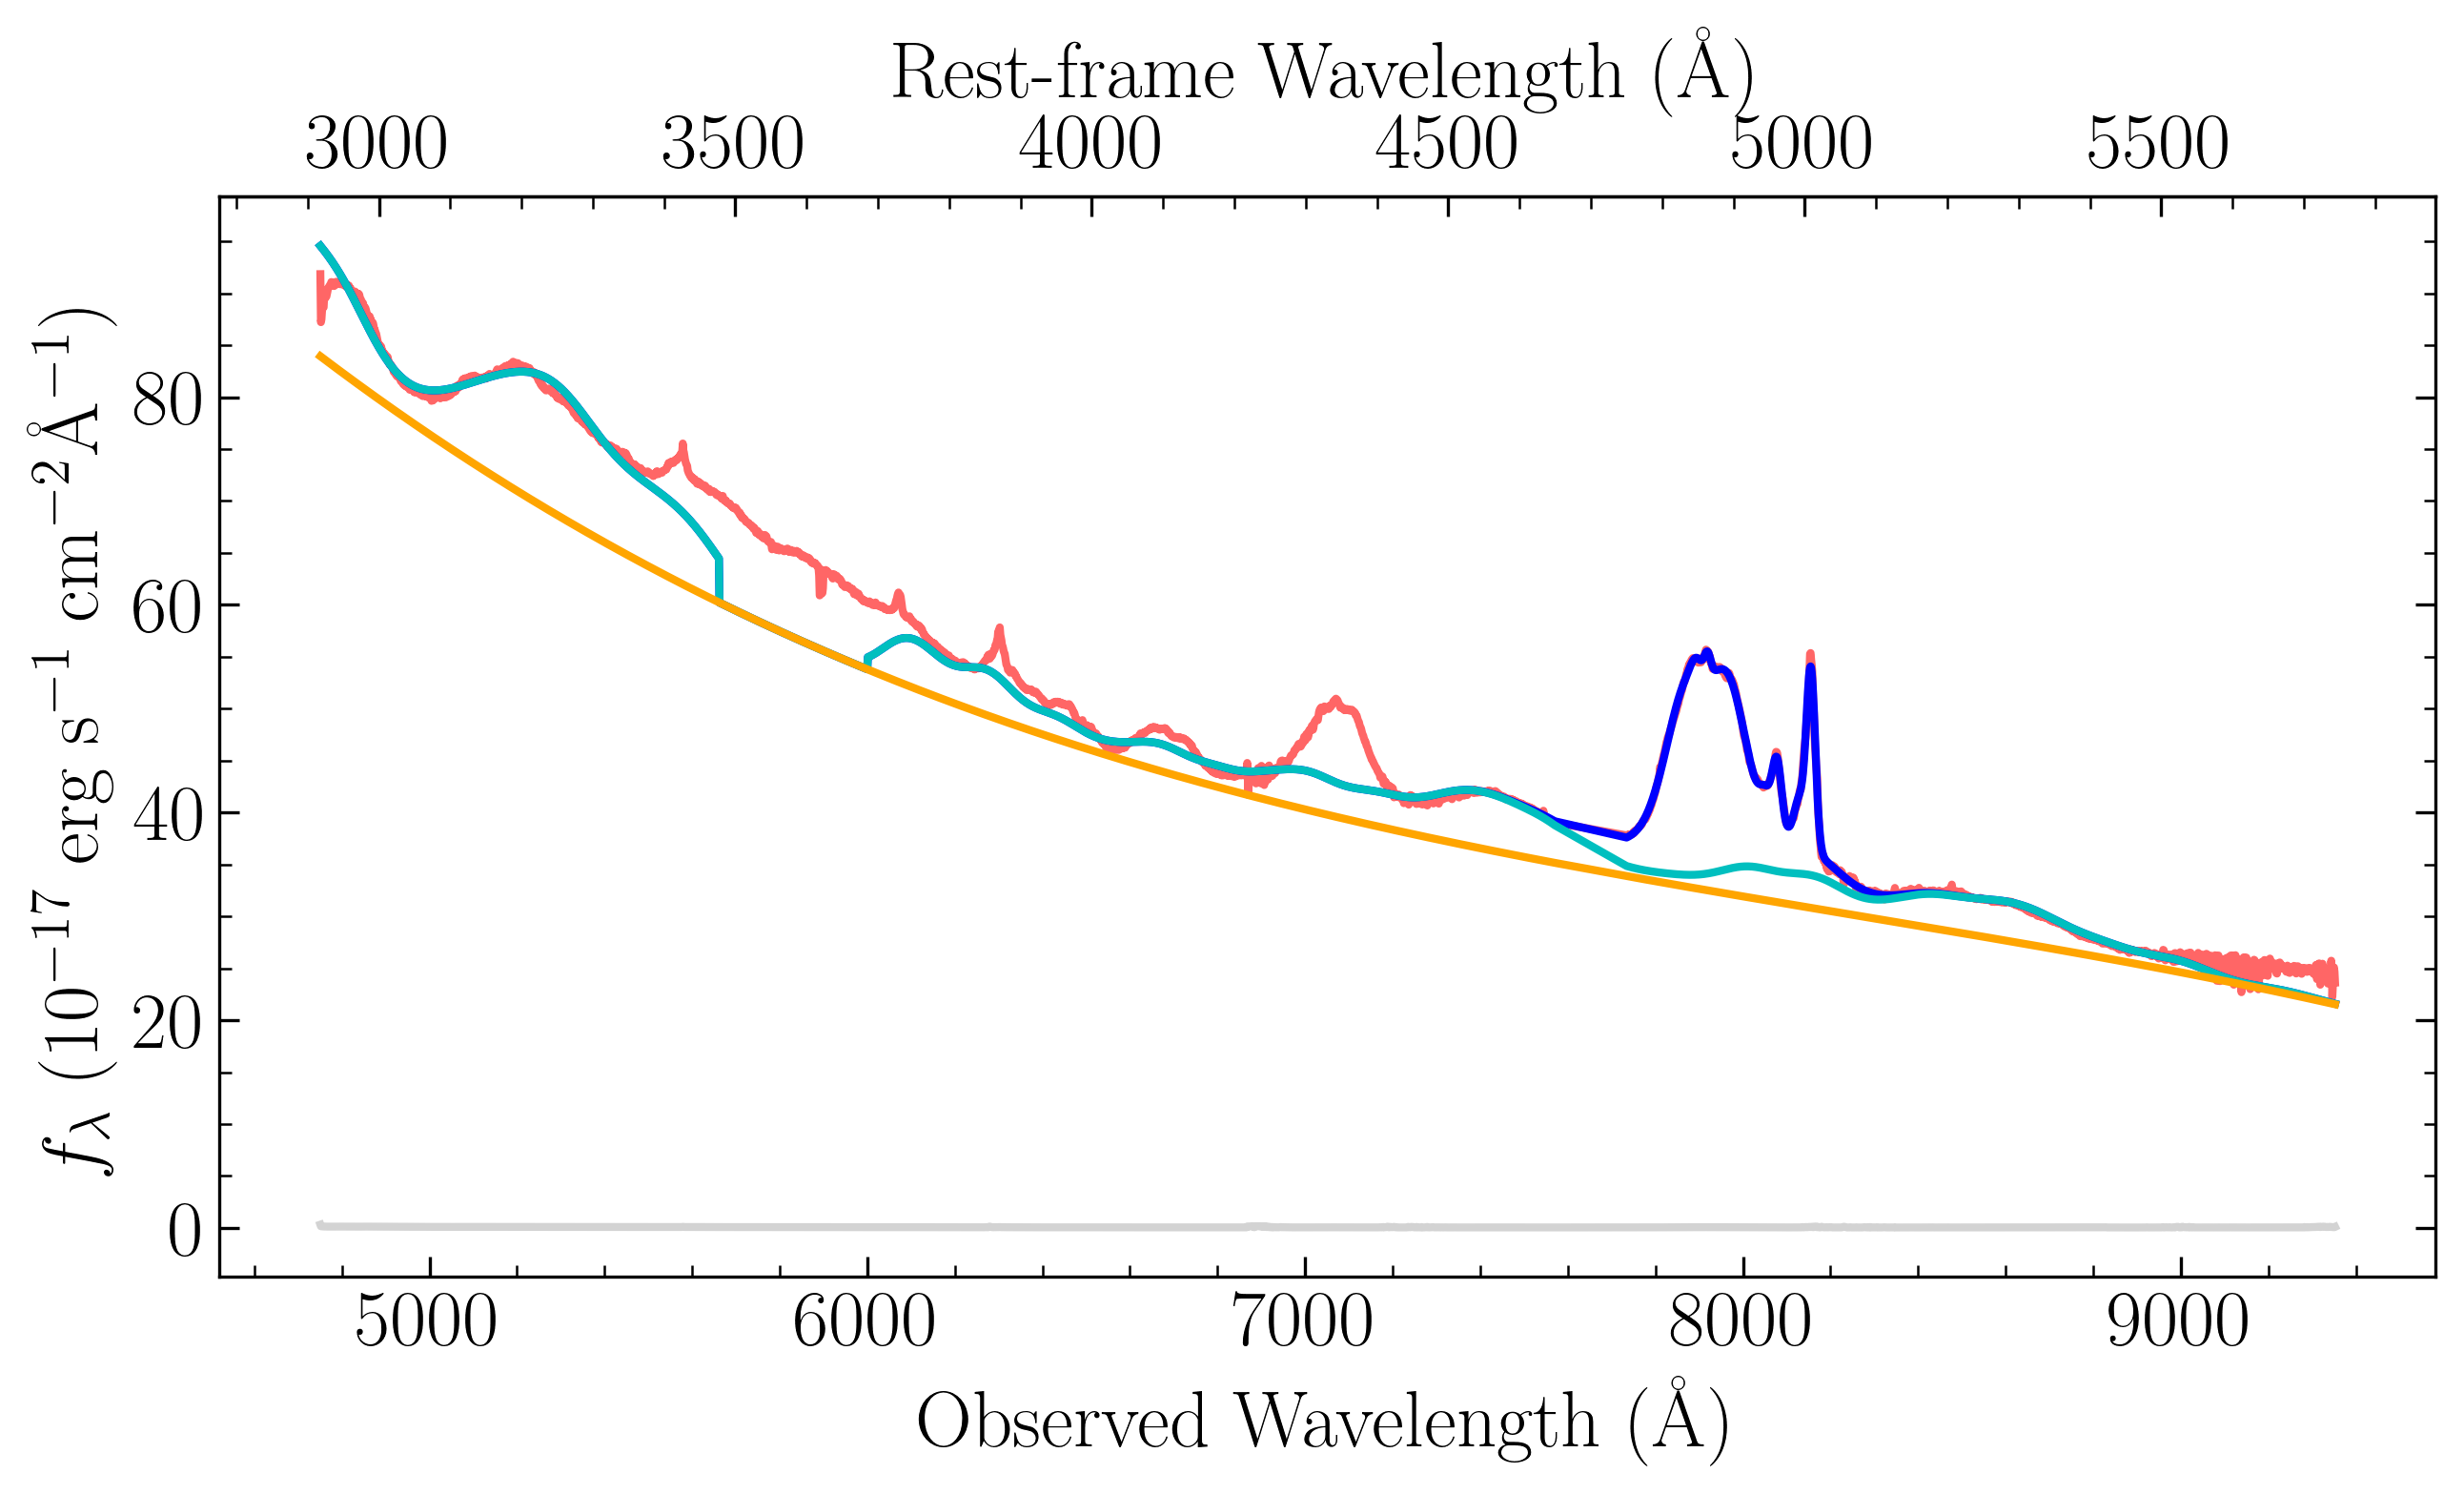

In [12]:
# Plot the Spectrum
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=300)
# ax.plot(wave_vac, flux * (1 + z), '--', color='r')
# ax.plot(wave_vac, flux_err, color='lightgrey')
ax.plot(q.wave * (1 + z), q.flux / (1 + z), color='r', alpha=0.6, lw=2)
ax.plot(q.wave * (1 + z), q.err / (1 + z), color='lightgrey', lw=2)
#To plot the whole model, we use Manygauss to reappear the line fitting results saved in gauss_result  
ax.plot(q.wave * (1 + z), q.Manygauss(np.log(q.wave), q.gauss_result) / (1 + z) + q.f_conti_model / (1 + z), 'b', label='line', lw=2)
ax.plot(q.wave * (1 + z), q.f_conti_model / (1 + z), 'c', lw=2)
ax.plot(q.wave * (1 + z), q.PL_poly_BC / (1 + z), 'orange', lw=2)



#ax.set_xlim(5200, 9300)
#ax.set_ylim(0, 100)
ax.set_xlabel(r'$\mathrm{Observed \; Wavelength \; (\AA)}$', size=20)
ax.set_ylabel(r'${f}_{\lambda} \; (10^{-17} \; \mathrm{erg \; s^{-1} \; cm^{-2} \AA^{-1}})$', size=20)


secax = ax.secondary_xaxis('top', functions=(obs2rest, rest2obs))
secax.minorticks_on()
secax.set_xlabel(r'$\mathrm{Rest \mbox{-} frame \; Wavelength \; (\AA)}$', size=20)
secax.tick_params(axis='x', which='major', direction='in', top='on', size=5, labelsize=20)
secax.tick_params(axis='x', which='minor', direction='in', top='on', size=3)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', direction='in', bottom='on', left='on', right='on', labelsize=20, size=5)
ax.tick_params(axis='both', which='minor', direction='in', bottom='on', left='on', right='on', size=3)

print('optical Fe flux (10^(-17) erg/s/cm^2): '+ q.conti_result[q.conti_result_name=='Fe_flux_4435_4685'][0])

Fe_flux_result, Fe_flux_type, Fe_flux_name = q.Get_Fe_flux(np.array([4400,4900]))
print('Fe flux within a specific range: \n' + Fe_flux_name[0] + ': ' + str(Fe_flux_result[0]))

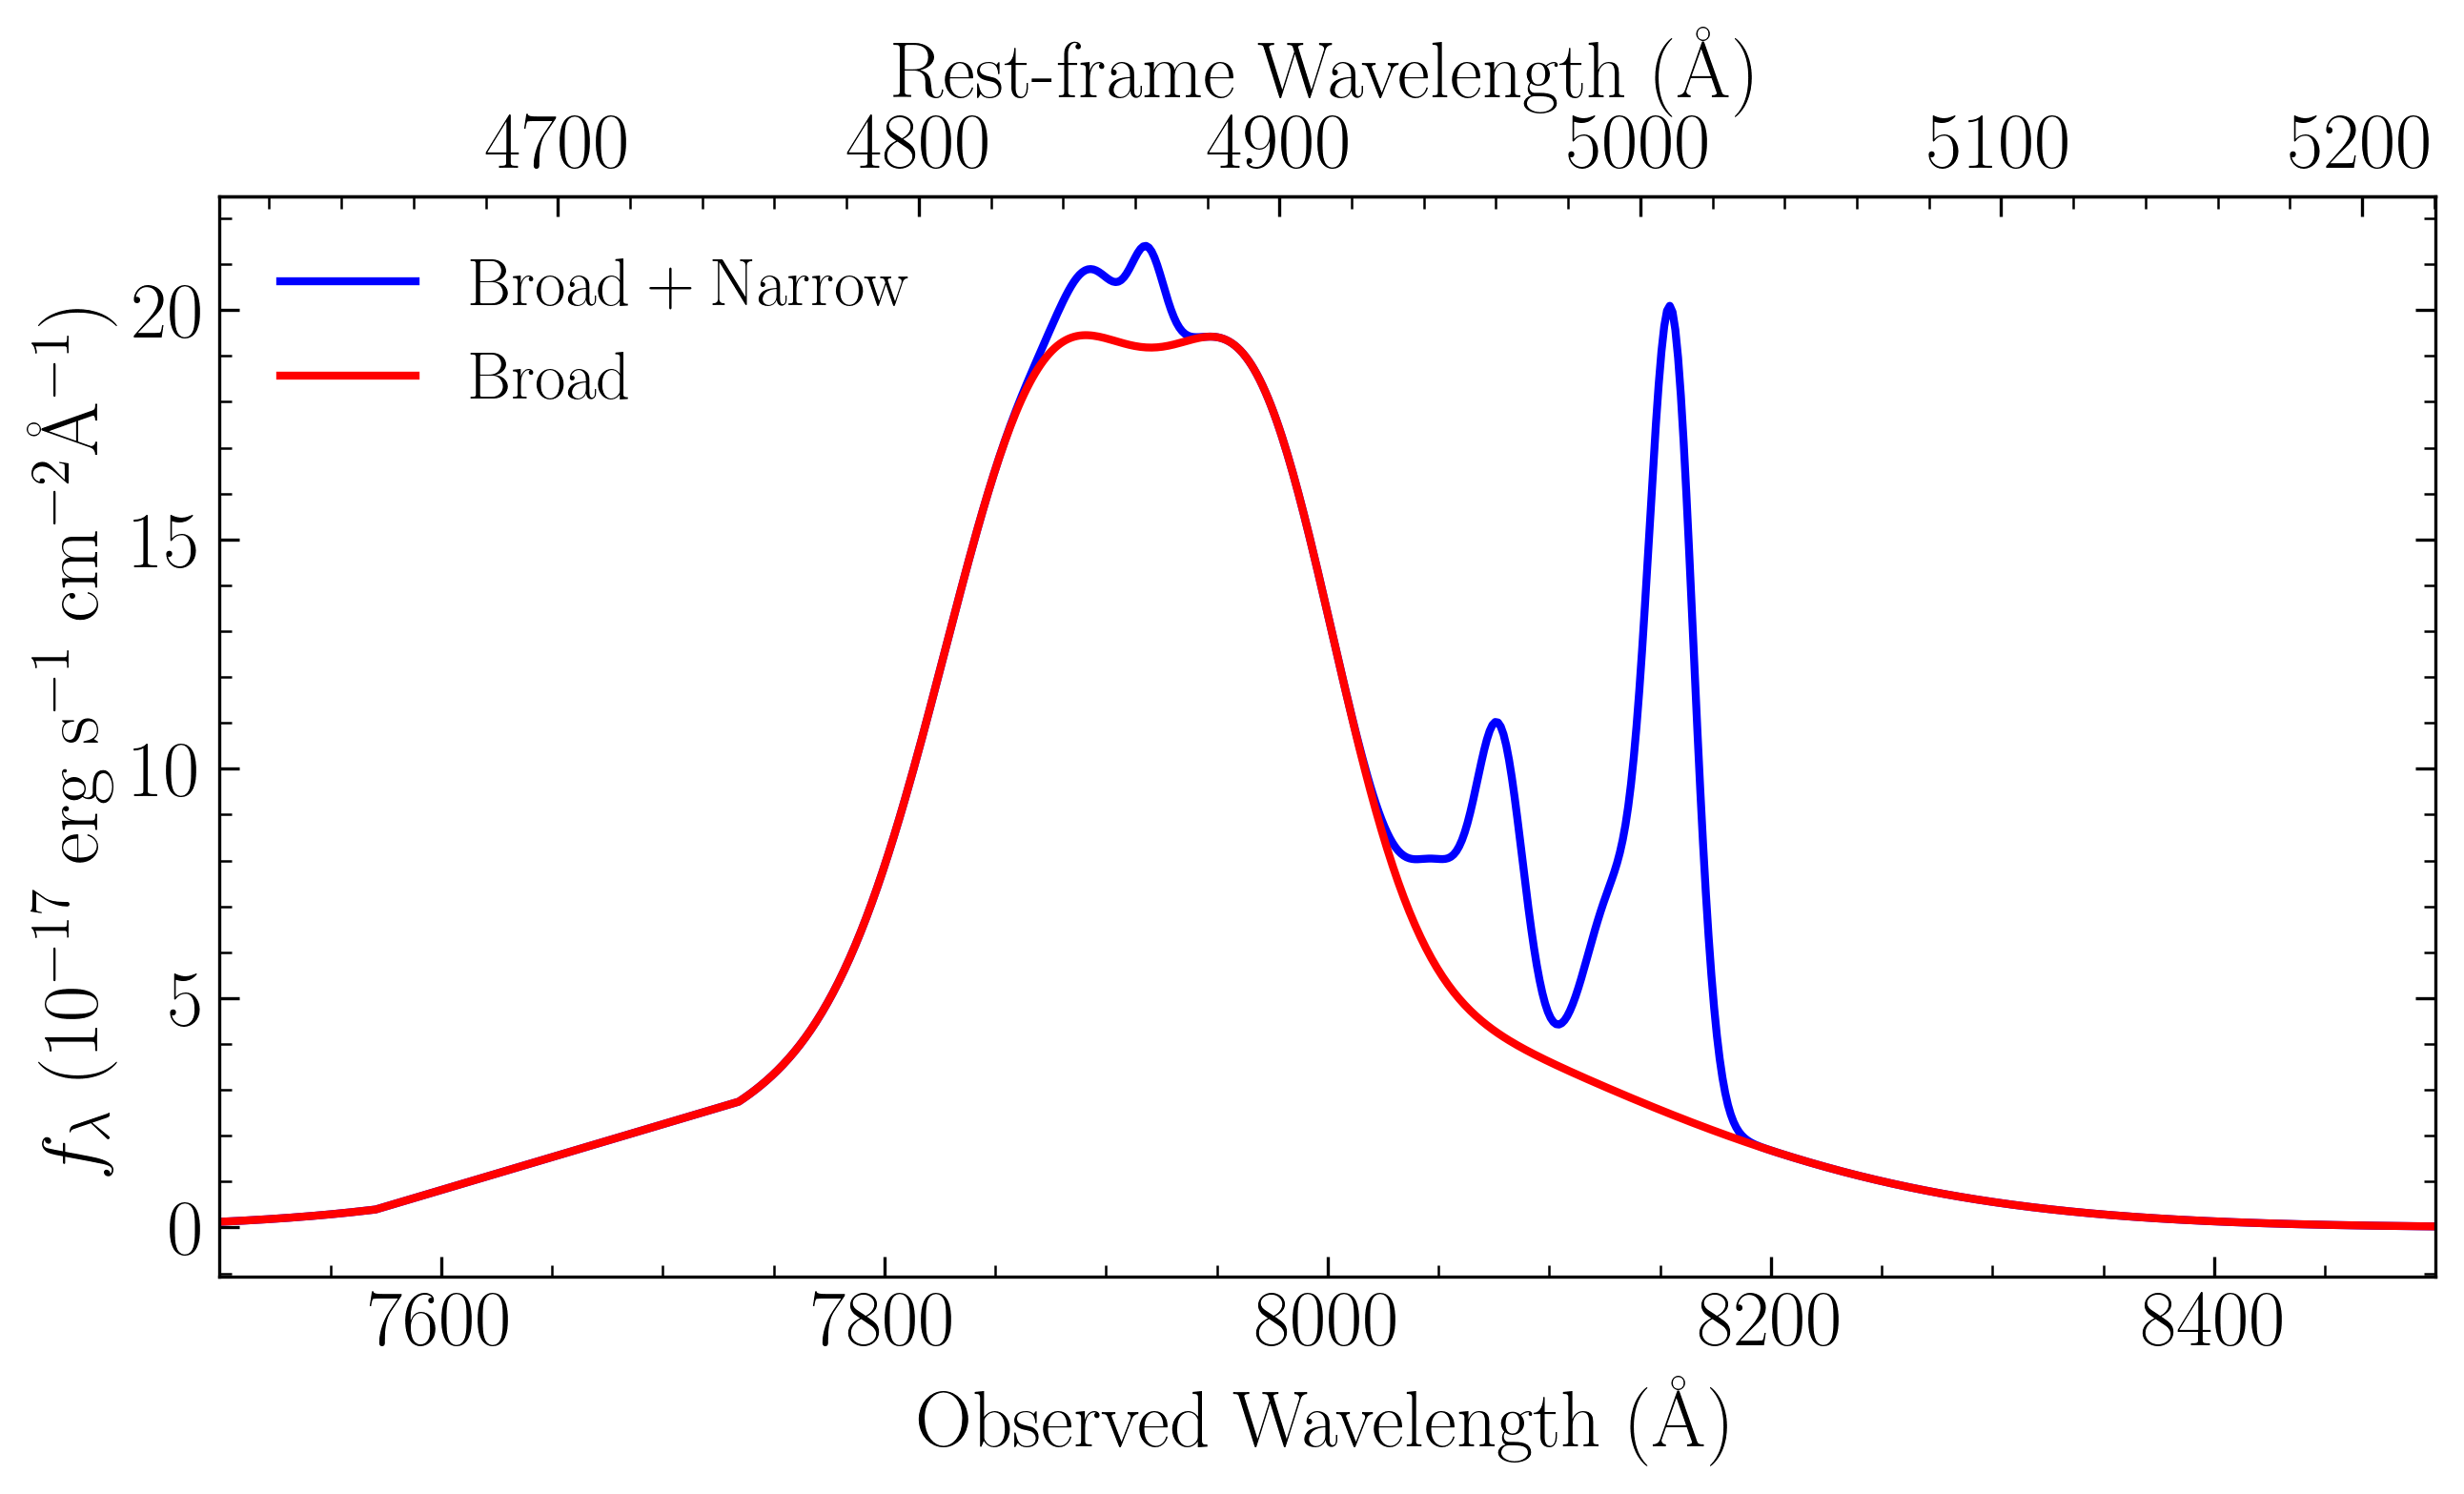

In [13]:
# Plot the Spectrum
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=300) 
ax.plot(q.wave * (1 + z), q.Manygauss(np.log(q.wave), q.gauss_result) / (1 + z), 'b', label=r'$\mathrm{Broad} + \mathrm{Narrow}$', lw=2)
ax.plot(q.wave * (1 + z), q.Manygauss(np.log(q.wave), q.gauss_result[:9]) / (1 + z), 'r', label=r'$\mathrm{Broad}$', lw=2)

ax.set_xlim(7500, 8500)
ax.set_xlabel(r'$\mathrm{Observed \; Wavelength \; (\AA)}$', size=20)
ax.set_ylabel(r'${f}_{\lambda} \; (10^{-17} \; \mathrm{erg \; s^{-1} \; cm^{-2} \AA^{-1}})$', size=20)


secax = ax.secondary_xaxis('top', functions=(obs2rest, rest2obs))
secax.minorticks_on()
secax.set_xlabel(r'$\mathrm{Rest \mbox{-} frame \; Wavelength \; (\AA)}$', size=20)
secax.tick_params(axis='x', which='major', direction='in', top='on', size=5, labelsize=20)
secax.tick_params(axis='x', which='minor', direction='in', top='on', size=3)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', direction='in', bottom='on', left='on', right='on', labelsize=20, size=5)
ax.tick_params(axis='both', which='minor', direction='in', bottom='on', left='on', right='on', size=3)
ax.legend(prop={'size': 17}, framealpha=0, loc=2, fontsize=15)

In [14]:
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
d_l = cosmo.luminosity_distance(z).to(u.cm).value
fwhm, sigma, ew, peak, area = q.line_prop(q.linelist[1][0], q.line_result[6:15], 'broad')
L_5100 = 4 * np.pi * d_l ** 2 * float(q.conti_result[13]) * (5100.0/3000.0) ** float(q.conti_result[14])
L_bol = 9.26 * L_5100
waveL_5100 = 5100 * L_5100
log_M_BH = np.log10((fwhm/1000) ** 2 * (waveL_5100 * 1e-17/1e44) ** 0.5) + 6.91
print("Broad Hb:")
print("FWHM (km/s)", np.round(fwhm, 1))
print("Sigma (km/s)", np.round(sigma, 1))
print("EW (A)", np.round(ew,1))
print("Peak (A)", np.round(peak,1))
print("area (10^(-17) erg/s/cm^2)" ,np.round(area,1))
print(r'$\mathrm{Log} \mathrm{M_{BH}}$', log_M_BH)
print(r'$\mathrm{L_{bol}}$', L_bol)


print(q.gauss_result)
print(q.linelist[2:5])
print(q.line_result)

np.exp(0.0017) / 4862.68 * 3e5

2*np.sqrt(2*np.log(2)) * (np.exp(0.0017) - 1) * 300000
#np.exp(0.0017) - 1

print(1200/3e5 * 1/2*np.sqrt(2*np.log(2)))

Broad Hb:
FWHM (km/s) 7822.4
Sigma (km/s) 4581.5
EW (A) 94.2
Peak (A) 4846.0
area (10^(-17) erg/s/cm^2) 4972.0
$\mathrm{Log} \mathrm{M_{BH}}$ 9.76612413867965
$\mathrm{L_{bol}}$ 2.499876136716583e+60
[3.41142096e-01 8.48419965e+00 6.25264843e-03 1.98217289e-01
 8.49582786e+00 4.64049859e-03 4.83440984e-01 8.49213344e+00
 2.05380454e-02 9.40734231e-03 8.48626264e+00 1.59999996e-03
 7.77598572e-03 8.48950397e+00 9.45309820e-04 1.45509186e-02
 8.50613817e+00 1.59999996e-03 3.46159210e-02 8.50936264e+00
 1.31254630e-03 2.68895604e-02 8.51575693e+00 1.59999996e-03
 8.55903851e-02 8.51889902e+00 1.23439177e-03]
[(4862.68, 'Hb', 4640., 5100., 'Hb_na', 2., 0.001, 0.00023, 0.0016, 0.01, 1., 1., 0., 0.002)
 (4960.3 , 'Hb', 4640., 5100., 'OIII4960c', 2., 0.001, 0.00023, 0.0016, 0.01, 1., 1., 0., 0.002)
 (5008.24, 'Hb', 4640., 5100., 'OIII5008c', 2., 0.001, 0.00023, 0.0016, 0.01, 1., 1., 0., 0.004)]
['Hb' '1' '9781.325377817217' '21.931222820217975' '56' '446'
 '0.3411420962465395' '8.484199647370

In [15]:
x = np.array([1, 2, 3, 4, 5])
x[1::3]

array([2, 5])